In [1]:
import torch
import torchvision
import math
import matplotlib.pyplot as plt

# Compute $\beta_t$

* $\beta_1 < \beta_2 < \ldots < \beta_T$

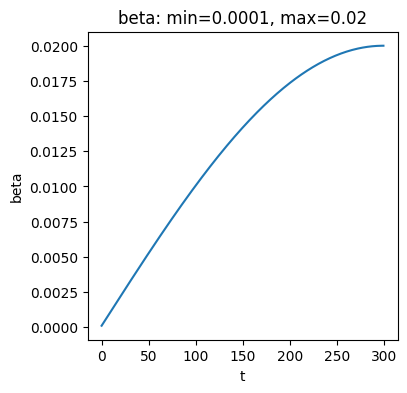

In [2]:
T = 300
beta_min = 0.0001
beta_max = 0.02
beta = torch.sin(torch.linspace(0, 0.5 * math.pi, T)) * (beta_max - beta_min) + beta_min

plt.figure(figsize=(4, 4))
plt.title(f'beta: min={beta_min}, max={beta_max}')
plt.xlabel('t')
plt.ylabel('beta')
plt.plot(beta)

# Compute $\alpha_t$

* $\alpha_t = \prod_{\tau=1}^t(1 - \beta_\tau)$

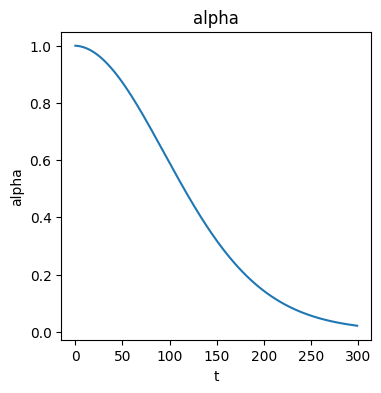

In [3]:
alpha = torch.cumprod(1 - beta, axis=0)

plt.figure(figsize=(4, 4))
plt.title('alpha')
plt.xlabel('t')
plt.ylabel('alpha')
plt.plot(alpha)


# Load dataset

In [4]:
import numpy as np
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

image_size = 32
batch_size = 1024

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale between [0, 1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # Switch CHW layout to HWC layout
    transforms.Lambda(lambda t: t * 255.),  #   Scale between [0, 255]
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),    # Convert from tensor to numpy array
    transforms.ToPILImage()
])

train_ds = CIFAR10(root='../../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

Files already downloaded and verified


# Define forward process function (=diffusion process function)

* Given $\textbf{x}$ and $t$, $z_t=\sqrt{\alpha_t}\textbf{x} + \sqrt{1 - \alpha_t}\epsilon_t$ 

In [5]:
def diffusion_process(x, t):
    """_summary_
        To broadcast alpha_t to the same shape as x, we need to expand alpha_t's dimensions by 1.
    """
    alpha_t = alpha[t]
    try:
        alpha_t_expanded = alpha_t.view(alpha_t.shape[0], *[1] * (len(x.shape) - 1))
    except: # alpha_t is a scalar -> single image
        alpha_t_expanded = alpha_t.view(1, *[1] * (len(x.shape) - 1))
    noise = torch.randn_like(x)
    
    return (torch.sqrt(alpha_t_expanded) * x + torch.sqrt(1 - alpha_t_expanded) * noise, noise)

# Check diffusion process

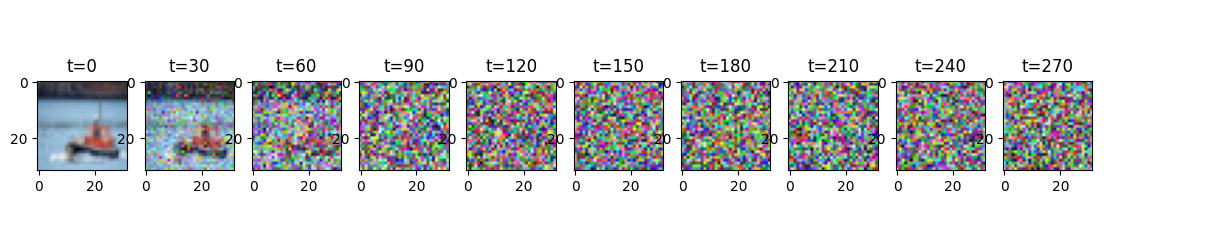

In [6]:
image = next(iter(train_loader))[0][0]
num_images = 10  # Number of images to show
step_size = T // num_images

plt.figure(figsize=(15, 3))
plt.axis('off')

for i in range(0, T, step_size):
    image, _ = diffusion_process(image, i)
    plt.subplot(1, num_images + 1, int(i / step_size) + 1)
    plt.title(f't={i}')    
    plt.imshow(reverse_transform(image))    # Transform scaled image(-1~1) to PIL image (0~255)
    

# Load modules including UNet

In [7]:
from model.model import EmbeddingUNet
model = EmbeddingUNet().cuda()
critereon = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)
alpha = alpha.cuda()
beta = beta.cuda()

# Training

* $\textbf{x} \sim \mathcal{D}$
* $t \sim \{1,\ldots,T\}$
* $\epsilon \sim \mathcal{N}(\epsilon | \textbf{0}, \textbf{I})$
* $\textbf{z}_t \leftarrow \sqrt{\alpha_t} \textbf{x} + \sqrt{1 - \alpha_t}\epsilon$
* $\mathcal{L}(\textbf{w}) \leftarrow ||\textbf{g}(\textbf{z}_t, \textbf{w}, t) - \epsilon||^2$

In [8]:
from tqdm.auto import tqdm
epochs = 100

progress_bar = tqdm(range(epochs))
for epoch in progress_bar:
    for idx, (images, _) in enumerate(train_loader):
        images = images.cuda()
        optimizer.zero_grad()
        
        t = torch.randint(0, T, (images.shape[0],)).cuda().long()
        z_t, noise = diffusion_process(images, t)
        noise_pred = model(z_t, t)
        
        loss = critereon(noise_pred, noise)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_description(f'Epoch {epoch} Loss: {loss.item():.4f}')
        progress_bar.set_postfix_str(f'Iter: {idx+1}/{len(train_loader)}, LR: {scheduler.get_last_lr()[0]:.2e}')

torch.save(model.state_dict(), 'model.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 3, 32, 32])


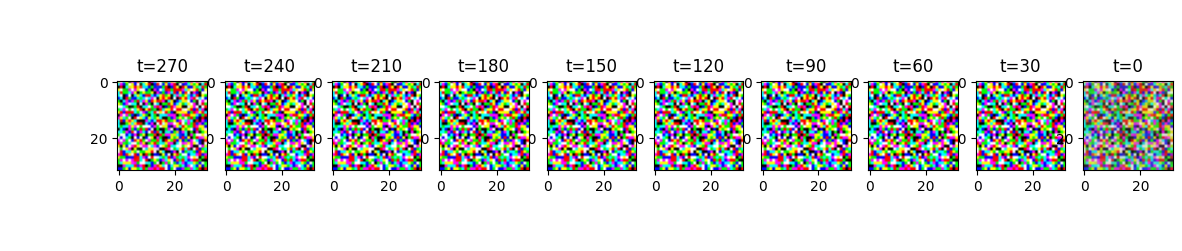

In [21]:
plt.figure(figsize=(15, 3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

z_t = torch.randn(1, 3, image_size, image_size).cuda()

for t in reversed(range(1, T)):
    t = torch.LongTensor([t]).cuda()
    alpha_t = alpha[t]
    variance = beta[t] * (1 - alpha[t - 1]) / (1 - alpha[t])
    
    u = 1 / torch.sqrt(alpha_t) * (z_t - beta[t] / torch.sqrt(1 - alpha_t) * model(z_t, t))
    z_t = u + torch.sqrt(variance) * torch.randn_like(u) 



    z_t = z_t.clamp(-1, 1)
    if t % stepsize == 0:
        plt.subplot(1, num_images + 1, int(t / stepsize) + 1)
        plt.title(f't={T - t.item()}')
        plt.imshow(reverse_transform(z_t[0].detach().cpu()))

t = torch.LongTensor([0]).cuda()
x = 1 / torch.sqrt(1 - beta[t]) * (z_t - beta[t] / torch.sqrt(1 - alpha[t]) * model(z_t, t))
x = x.clamp(-1, 1)
print(x.shape)
x = reverse_transform(x[0].detach().cpu())
plt.subplot(1, num_images + 1, num_images + 1)
plt.title(f't={0}') 
plt.imshow(x)